In [1]:
%matplotlib inline
import numpy as np
import random as rm
import math
import matplotlib.pyplot as plt
import statistics as stat

## The Data Faker
### This function randomly generates points and labels them according to whether they are above or below a line, either also randomly generated or user specified. The determines how many points to generate, whether the generatine line is random or not, and how far away from the generating line the points are required to be.  The data points are not allowed to all be on one side of the generating line - at least one point must be on the opposite side.

In [2]:
def data_faker(N, m, b, c=1, gamma=0.0000001, rand_div = 'yes'):
    
    if rand_div == 'yes':
        
        cosine_sign_choice = rm.random()
        
        if cosine_sign_choice < 0.5:
            cosine_sign = -1
        else:
            cosine_sign = 1
            
        cosine = cosine_sign * rm.random()
        
        angle = math.acos(cosine)
        
        m = math.sin(angle)/math.cos(angle)
        
        intercep_sign_choice = rm.random()
        
        if intercep_sign_choice < 0.5:
            b_sign = -1
        else:
            b_sign = 1
            
        b = b_sign * rm.random()
    
    alpha = math.atan(m)
    bd = gamma / math.cos(alpha)
    
    if 0<=abs(alpha)<45:
        gamma_max = (1/math.cos(alpha))*c
    elif 45<=abs(alpha)<90:
        gamma_max = (1/math.sin(alpha))*c
        
    points = np.empty([N,3])
        
    if gamma > gamma_max:
        print('gamma is greater than allowed gamma_max for this slope')
        return points, m, b
    
    all_points_on_1_side = True
    
    while all_points_on_1_side:
        for i in range(N):

            good = 0

            while good == 0:

                x_sign_choice = rm.random()

                if x_sign_choice < 0.5:
                    x_sign = -1
                else:
                    x_sign = 1

                x_i = x_sign * rm.random() *c
                #---------------------------------------

                y_sign_choice = rm.random()

                if y_sign_choice < 0.5:
                    y_sign = -1
                else:
                    y_sign = 1

                y_i = y_sign * rm.random() *c
                #----------------------------------------

                if y_i < m*x_i+b:
                    l_i = 1
                elif y_i > m*x_i+b:
                    l_i = -1

                if l_i == 1 and y_i < m*x_i+(b-bd):
                    good = 1
                elif l_i ==-1 and y_i > m*x_i+(b+bd):
                    good = 1

            points[i,0] = x_i
            points[i,1] = y_i
            points[i,2] = l_i
            
        if abs(np.sum(points,0)[2]) != N:
            all_points_on_1_side = False
         
    return points, m, b

### The test function: used by the Perceptron algorithm to determine whether weight vector requires adjustment 

In [3]:
step_function = lambda f: -1 if f <= 0 else 1

## The Perceptron algorithm

In [17]:
def perceptron(points, w=(0,0,0), eta=0.5, n_iter=5000, video='no', m=0, b=0, vid_dir = './vid'):
    
    test_training = np.ones([len(points),4])
    test_training[:,1:] =  points
    
    misclassed = True
    num_slope_adjusts = 0
    n = 0
    num_points_tested = 0
    slope = 0
    intercept = 0
    
    while (misclassed and n < n_iter):
        n += 1
        wrong_line = 0
        
        for test_val in test_training:
            point = test_val[:3]
            desired = test_val[3]
            result = np.dot(w, point)
            f = step_function(result)
            num_points_tested += 1
            
            if f != desired:
                wrong_line += 1
                num_slope_adjusts += 1
                w += eta * desired * point
                
                if w[2] != 0:
                    slope = -(w[1] / w[2])
                    intercept = -(w[0] / w[2])
                else:
                    slope = 0
                    intercept = 0
                
                if video == 'yes':
                        scatter_plot_vid(points, m, b, 
                                         slope, intercept, 
                                         num_points_tested, vid_dir = './vid')
        
        if wrong_line == 0: 
            misclassed = False

        
    return slope, intercept, n, num_slope_adjusts

### Theoretical maximum time to convergence, as measured by number of weight vector adjustments

In [18]:
def theoretical_function(w, gamma, c=10):
    #number of weight vector adjustments = n
    n_max = w*w*c*c/(gamma*gamma)
    return n_max

## Experiment 1: Number of weight vector adjustments vs Number of data points
### NOTE: Large values of N require a VERY long iteration time!! Keep this in mind when choosing the range!

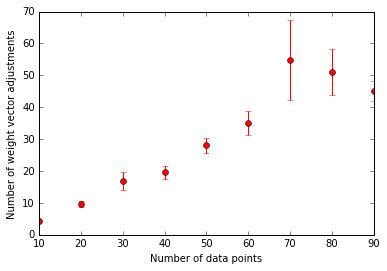

In [19]:
N = 0
N_list = []
k_ave_list = []
k_SDM_list = []
i = 0
num_trials = 1000
for N in range(10, 100, 10):
    k_list = []
    N_list.append(N)
    for i in range(num_trials):
        points, m, b = data_faker(N, 1, 0, c=10, rand_div='yes')
        p_m, p_b, n, k = perceptron(points)
        k_list.append(k)
    k_ave = stat.mean(k_list)
    k_SDM = stat.stdev(k_list) / math.sqrt(num_trials)
    k_ave_list.append(k_ave)
    k_SDM_list.append(k_SDM)

time_plot_1 = plt.errorbar(N_list, k_ave_list, yerr=k_SDM_list, fmt='o', color='r')
plt.title('')
plt.xlabel('Number of data points')
plt.ylabel('Number of weight vector adjustments')

## Experiment 2: Number of weight vector adjustments vs Learning Rate

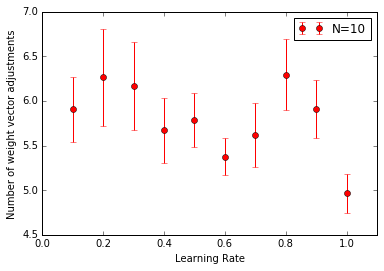

In [20]:
num_trials = 1000
eta = 0
eta_array = np.arange(0.1, 1.1, 0.1)
i = 0

N = 10
n_ave_list_10 = []
n_SDM_list_10 = []
for eta in eta_array:
    n_list = []
    #eta_list.append(eta)
    for i in range(num_trials):
        points, m, b = data_faker(N, 1, 0, c=10, rand_div='no')
        p_m, p_b, k, n = perceptron(points, eta=eta)
        n_list.append(n)
    n_ave = stat.mean(n_list)
    n_SDM = stat.stdev(n_list) / math.sqrt(num_trials)
    n_ave_list_10.append(n_ave)
    n_SDM_list_10.append(n_SDM)

plt.figure()
N10_plot = plt.errorbar(eta_array, n_ave_list_10, yerr=n_SDM_list_10, fmt='o', color='r', label='N=10')
plt.legend()
plt.xlim(0.0, 1.1)
plt.ylabel('Number of weight vector adjustments')
plt.xlabel('Learning Rate')

## Experiment 3: Number of weight vector adjustments vs Gamma 

(0, 50)

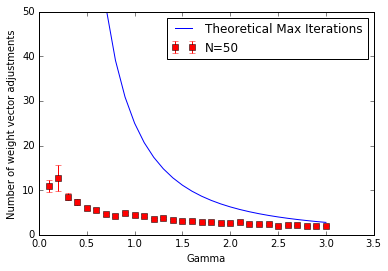

In [21]:
num_trials = 100
gam = 0
gam_array = np.arange(0.1, 3.1, 0.1)
i = 0

N = 50
n_ave_list_50 = []
n_SDM_list_50 = []
for gam in gam_array:
    n_list = []
    for i in range(num_trials):
        points, m, b = data_faker(N, 1, 0, c=10, gamma=gam, rand_div='yes')
        p_m, p_b, k, n = perceptron(points)
        n_list.append(n)
    n_ave = stat.mean(n_list)
    n_SDM = stat.stdev(n_list) / math.sqrt(num_trials)
    n_ave_list_50.append(n_ave)
    n_SDM_list_50.append(n_SDM)
    
# calculate the theoretical curve
x_dummy = np.arange(0.1, 3.1, 0.1)
y_dummy = np.empty(len(x_dummy))
for i, x in enumerate(x_dummy):
    y_dummy[i] = theoretical_function(0.5, gamma=x)
    
plt.figure()
N50_plot = plt.errorbar(gam_array, n_ave_list_50, yerr=n_SDM_list_50, fmt='s', color='r', label='N=50')
plt.legend()

plt.plot(x_dummy, y_dummy, label='Theoretical Max Iterations')
plt.legend()
plt.ylabel('Number of weight vector adjustments')
plt.xlabel('Gamma')
plt.ylim(0,50)

## Experiment 4: Difference between generating line and final perceptron line (in degrees)

In [22]:
def difference_between_lines(m1, b1, m2, b2):    
    # calcualate angle between two lines:
    if m1*m2 != -1:
        tnAngle = (m1 - m2) / (1 + (m1*m2))
        angle = math.atan(tnAngle)
        angle = -1 * angle * 180/math.pi
    else:
        angle = 90.
    angle_diff = math.sqrt(angle*angle)

    # include difference in y-intercepts, if needed
    # actual difference is typically negligible
    interc_diff = math.sqrt((b2-b1)*(b2-b1))

    total_diff = angle_diff + interc_diff
    return(angle_diff, interc_diff)

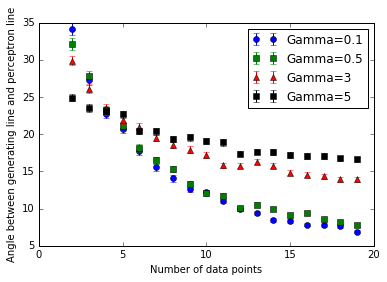

In [23]:
N = 0
N_list = []
diff_ave_list_01 = []
diff_SDM_list_01 = []
i = 0
num_trials = 1000
for N in range(2, 20, 1):
    diff_list = []
    N_list.append(N)
    for i in range(num_trials):
        points, m, b = data_faker(N, 1, 0, c=10, gamma=0.1, rand_div='yes')
        p_m, p_b, k, n = perceptron(points)
        m_diff, b_diff = difference_between_lines(p_m, p_b, m, b)
        diff_list.append(m_diff)
    diff_ave = stat.mean(diff_list)
    diff_SDM = stat.stdev(diff_list) / math.sqrt(num_trials)
    diff_ave_list_01.append(diff_ave)
    diff_SDM_list_01.append(diff_SDM)
    

diff_ave_list_05 = []
diff_SDM_list_05 = []

for N in range(2, 20, 1):
    diff_list = []
    for i in range(num_trials):
        points, m, b = data_faker(N, 1, 0, c=10, gamma=0.5, rand_div='yes')
        p_m, p_b, k, n = perceptron(points)
        m_diff, b_diff = difference_between_lines(p_m, p_b, m, b)
        diff_list.append(m_diff)
    diff_ave = stat.mean(diff_list)
    diff_SDM = stat.stdev(diff_list) / math.sqrt(num_trials)
    diff_ave_list_05.append(diff_ave)
    diff_SDM_list_05.append(diff_SDM)
    

diff_ave_list_3 = []
diff_SDM_list_3 = []

for N in range(2, 20, 1):
    diff_list = []
    for i in range(num_trials):
        points, m, b = data_faker(N, 1, 0, c=10, gamma=3, rand_div='yes')
        p_m, p_b, k, n = perceptron(points)
        m_diff, b_diff = difference_between_lines(p_m, p_b, m, b)
        diff_list.append(m_diff)
    diff_ave = stat.mean(diff_list)
    diff_SDM = stat.stdev(diff_list) / math.sqrt(num_trials)
    diff_ave_list_3.append(diff_ave)
    diff_SDM_list_3.append(diff_SDM)  
    
diff_ave_list_5 = []
diff_SDM_list_5 = []

for N in range(2, 20, 1):
    diff_list = []
    for i in range(num_trials):
        points, m, b = data_faker(N, 1, 0, c=10, gamma=5, rand_div='yes')
        p_m, p_b, k, n = perceptron(points)
        m_diff, b_diff = difference_between_lines(p_m, p_b, m, b)
        diff_list.append(m_diff)
    diff_ave = stat.mean(diff_list)
    diff_SDM = stat.stdev(diff_list) / math.sqrt(num_trials)
    diff_ave_list_5.append(diff_ave)
    diff_SDM_list_5.append(diff_SDM)
    
plt.figure()  
diff_plot_01 = plt.errorbar(N_list, diff_ave_list_01, yerr=diff_SDM_list_01, fmt='o', color='b', label='Gamma=0.1')
plt.legend()

diff_plot_05 = plt.errorbar(N_list, diff_ave_list_05, yerr=diff_SDM_list_05, fmt='s', color='g', label='Gamma=0.5')
plt.legend()

diff_plot_1 = plt.errorbar(N_list, diff_ave_list_3, yerr=diff_SDM_list_3, fmt='^', color='r', label='Gamma=3')
plt.legend()

diff_plot_5 = plt.errorbar(N_list, diff_ave_list_5, yerr=diff_SDM_list_5, fmt='s', color='k', label='Gamma=5')
plt.legend()

plt.xlim(0,20)
plt.ylabel('Angle between generating line and perceptron line')
plt.xlabel('Number of data points')